$\text{Nome: Rafael Gonçalves  -  RA: 186062}$

# Parte I - Atividades teóricas

## Exercício 1

a) $P(A^C) = 1 - P(A) = 1 - \frac{1}{3} = \frac{2}{3}$

b) $P(A^C \cup B) = P(A^C) + P(B) - P(A^CB) = P(A^C) + P(B) - (P(B) - P(AB)) = P(A^C) + P(AB) = \frac{2}{3} + \frac{1}{6} = \frac{5}{6}$

c) $P(A \cup B^C) = P(A) + P(B^C) - P(AB^C) = P(B^C) + P(AB) = (1 - P(B)) + P(AB) = (1 - \frac{1}{4}) + \frac{1}{6} = \frac{5}{12}$

d) $P(AB^C) = P(A) + P(B^C) - P(A \cup B^C) = \frac{1}{3} + \frac{3}{4} - \frac{5}{12} = \frac{8}{12}$

e) $P(A^C \cup B^C) = P(A^C) + P(B^C) - P(A^CB^C) = \frac{2}{3} + \frac{3}{4} - \frac{5}{6} = \frac{7}{12}$

## Exercício 2

a) $$
    F_X(x) = P(X \leq x) = \int\limits_{-\infty}^x f_X(\xi) d\xi = \int\limits_{-\infty}^x \frac{1}{2} d\xi = \left[ \frac{1}{2}\xi \right]^x_0 = \frac{1}{2} x, \forall X \in [0, 2]
$$

b)

$E\{X\} = \int\limits_{-\infty}^{\infty} xf_X(x)dx = \int\limits_0^2 \frac{1}{2}x dx = \left[\frac{x^2}{4}\right]^2_0 = 1$

$E\{X^2\} = \int\limits_{-\infty}^{\infty} x^2f_X(x)dx = \int\limits_0^2 \frac{1}{2}x^2 dx = \left[\frac{x^3}{6}\right]^2_0 = \frac{4}{3}$

$E\{X^3\} = \int\limits_{-\infty}^{\infty} x^3f_X(x)dx = \int\limits_0^2 \frac{1}{2}x^3 dx = \left[\frac{x^4}{8}\right]^2_0 = 2$

## Exercício 3

a) $X_2$, pois quanto mais próximo da distribuição uniforme, mais difícil é acertar o resultado de um evento aleatório "chutando um valor", ou seja, a variável aleatória $X_2$ carrega mais informação que a variável aleatória $X_1$, pois neste último eu poderia supor que o resultado será sempre 3 com uma taxa de acertos de 40% contra uma taxa de acertos de 25% para qualquer valor estimado para $X_2$ se não tivermos nenhuma informação _a priori_.

b)

$H(X_1) = - \sum\limits_x p(X_1)log_2[p(X_1)] = -[0,1(-3,32) + 0,2(-2,32) + 0,3(-1,74) + 0,4(-1,32)] = 1,85$

$H(X_2) = - \sum\limits_x p(X_2)log_2[p(X_2)] = - [0,25 (-2) + 0,25 (-2) + 0,25 (-2) + 0,25(-2)] = 2$

c)

$D(P_1 || P_2) = \sum\limits_x p(X_1)log_2\left[\frac{p(X_1)}{p(X_2)}\right] = 0,1(-1,32) + 0,2(-0,32) + 0,3(-0,26) + 0,4(-0,68) = -0,54$

$D(P_2 || P_1) = \sum\limits_x p(X_2)log_2\left[\frac{p(X_2)}{p(X_1)}\right] = 0,25(1.32 +  0.32 - 0.26 -0.68) = 0,18$

## Exercício 4

a) $\mu_{ML} = arg max_\theta p(x|\mu) = arg max_\theta log[p(x|\mu)] = arg max_\theta \frac{p(x\mu)}{p(\mu)} = x$

b) $\mu_{ML} = arg max_\theta p(\mathbf{x}|\mu) = arg ax_\theta log[p(\mathbf{x}|\mu)] = arg max_\theta \sum\limits_{k=1}^{N} log[p(x_K|\mu)] =  arg max_\theta \sum\limits_{k=1}^{N} log\left[\frac{p(x_K\mu)}{p(\mu)}\right] $

c) 

# Parte II - Atividade computacional

### Importa bibliotecas

In [1]:
import os
import urllib.request
import random
random.seed = 42
import numpy as np
np.random.seed = 42
import matplotlib.pyplot as plt
%matplotlib inline

### Download dataset

In [2]:
data_url = 'http://www.dca.fee.unicamp.br/~lboccato/sunspot.txt'
data_dir = os.path.abspath(os.path.relpath('../data'))
data_path = os.path.join(data_dir, 'sunspot.txt')

urllib.request.urlretrieve(data_url, data_path)

('/home/rafael/inbox/machine-learning/data/sunspot.txt',
 <http.client.HTTPMessage at 0x7f767041aef0>)

In [3]:
%%bash
head ../data/sunspot.txt

 1749   58.0  62.6  70.0  55.7  85.0  83.5  94.8  66.3  75.9  75.5 158.6  85.2
 1750   73.3  75.9  89.2  88.3  90.0 100.0  85.4 103.0  91.2  65.7  63.3  75.4
 1751   70.0  43.5  45.3  56.4  60.7  50.7  66.3  59.8  23.5  23.2  28.5  44.0
 1752   35.0  50.0  71.0  59.3  59.7  39.6  78.4  29.3  27.1  46.6  37.6  40.0
 1753   44.0  32.0  45.7  38.0  36.0  31.7  22.0  39.0  28.0  25.0  20.0   6.7
 1754    0.0   3.0   1.7  13.7  20.7  26.7  18.8  12.3   8.2  24.1  13.2   4.2
 1755   10.2  11.2   6.8   6.5   0.0   0.0   8.6   3.2  17.8  23.7   6.8  20.0
 1756   12.5   7.1   5.4   9.4  12.5  12.9   3.6   6.4  11.8  14.3  17.0   9.4
 1757   14.1  21.2  26.2  30.0  38.1  12.8  25.0  51.3  39.7  32.5  64.7  33.5
 1758   37.6  52.0  49.0  72.3  46.4  45.0  44.0  38.7  62.5  37.7  43.0  43.0


### Importa dataset

In [4]:
dataset = np.loadtxt(data_path, usecols=range(1,13))

In [5]:
dataset.shape

(266, 12)

### Cria conjunto de teste e conjunto de treino

In [6]:
K = 20 # temporal window size
N = np.size(dataset) # number of samples
M = N-K # number of samples of new dataset
X = np.empty((M,K))
y = np.empty((M,1))

for i in range(M):
    for k in range(K):
        X[i][k] = dataset.flatten()[(i+K) - (k + 1)]
    y[i][0] = (dataset.flatten()[i+K])

In [7]:
n_test_samples = 5*12 # 5 years

X_train = np.array(X[:-n_test_samples])
y_train = np.array(y[:-n_test_samples])

X_test = np.array(X[-n_test_samples:])
y_test = np.array(y[-n_test_samples:])

In [8]:
Phi_train = np.column_stack((np.ones(X_train.shape[0]), X_train))
Phi_test = np.column_stack((np.ones(X_test.shape[0]), X_test))

In [9]:
Phi_train.shape, y_train.shape, Phi_test.shape, y_test.shape

((3112, 21), (3112, 1), (60, 21), (60, 1))

### Define RMSE como critério de erro

In [10]:
def rmse(output, target):
    """Root Mean Squared Error"""
    error = np.subtract(output, target)
    error = np.square(error)
    error = np.sum(error)/np.size(error)
    return np.sqrt(error)

### Regressão linear na forma matricial

In [11]:
linreg = lambda W, Phi: np.dot(Phi, W)

## a) Solução ótima com MMQ

In [12]:
mmq = lambda Phi, y: np.dot(np.dot(np.linalg.inv(np.dot(Phi.T, Phi)), Phi.T), y)

In [13]:
w = mmq(Phi_train, y_train)

In [14]:
out_train = linreg(w, Phi_train)
out_test = linreg(w, Phi_test)

In [15]:
print("RMSE do conjunto de treino: {}\nRMSE do conjunto de teste: {}".format(rmse(out_train, y_train), rmse(out_test, y_test)))

RMSE do conjunto de treino: 15.370232088543426
RMSE do conjunto de teste: 14.249451112744566


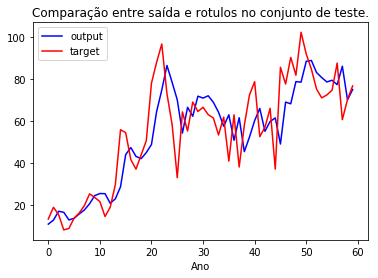

In [16]:
plt.plot(out_test, 'b')
plt.plot(y_test, '-r')
plt.xlabel('Ano')
plt.legend(('output', 'target'))
plt.title('Comparação entre saída e rotulos no conjunto de teste.')
plt.show()

## b) Seleção de atributos, validação cruzada e regularização

In [17]:
mmq_l2 = lambda Phi, y, l: np.dot(np.dot(np.linalg.inv(np.dot(Phi.T, Phi) + l*np.eye(Phi.shape[1])), Phi.T), y)

### K-fold

In [18]:
def kfold(Phi, y, L, lamb_vec, v=0):
    """Returns best rmse and lambda (ridge regularization param) using L folds for cross-validation."""
    N = Phi.shape[0]
    min_rmse = 9999
    min_lamb = None
    M = N//L # size of folds
    for l in lamb_vec:
        error = 0
        for i in range(L):
            train_slc = list(range(i*M)) + list(range((i+1)*M, N))
            test_slc = list(range(i*M,(i+1)*M))
            w = mmq_l2(Phi[train_slc], y[train_slc], l)
            out = linreg(w, Phi[test_slc])
            error += rmse(out, y[test_slc])
            if v:
                print(error)
        error /= L
        if v:
            print('[', error, ']')
        if error < min_rmse:
            min_rmse = error
            min_lamb = l
            
    return (min_rmse, min_lamb)

### Wrapper - backward elimination

In [19]:
def wrapper(Phi, y, K, L, lamb_vec, v=1):
    """Backward selection of the N inputs using K fold cross validation for choosing ridge regression hyperparameter."""
    idx_vec = list(range(21))
    idx_mask = [1]*21
    mask = [e for e, f in zip(idx_vec, idx_mask) if f]
    ret = []
    (error, lamb) = kfold(Phi, y, L, lamb_vec, v>1)
    ret.append([0, error, lamb, mask])
    for i in range(1, K):
        min_error = 9999
        for j in mask[1:]:
            idx_mask[j] = 0
            mask = [e for e, f in zip(idx_vec, idx_mask) if f]
            (error, lamb) = kfold(Phi[:,mask], y, L, lamb_vec, v>1)
            idx_mask[j] = 1
            if error < min_error:
                min_error = error
                min_l = lamb
                min_idx = j
            if v > 1:
                print("\tN = {} | min RMSE = {:.4f} | drop= {} | lambda = {}".format(i, error, j, lamb))
        idx_mask[min_idx] = 0
        mask = [e for e, f in zip(idx_vec, idx_mask) if f]
        ret.append([i, error, lamb, mask])
        if v > 0:
            print("min RMSE = {:13.10f} | lambda = {} | Features: ".format(min_error, min_l), end="")
            print(mask)
            print()
    return ret

In [20]:
lamb_vec = [0, 1, 3, 6, 10, 30, 60, 100, 300, 600]
vec = wrapper(Phi_train, y_train, 20, 5, lamb_vec, 1)

min RMSE = 15.4457303812 | lambda = 60 | Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20]

min RMSE = 15.4368804137 | lambda = 60 | Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20]

min RMSE = 15.4318584162 | lambda = 60 | Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20]

min RMSE = 15.4287851897 | lambda = 60 | Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 16, 18, 19, 20]

min RMSE = 15.4261583045 | lambda = 60 | Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 18, 19, 20]

min RMSE = 15.4243687988 | lambda = 60 | Features: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 16, 18, 19, 20]

min RMSE = 15.4231246980 | lambda = 60 | Features: [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 16, 18, 19, 20]

min RMSE = 15.4214497739 | lambda = 60 | Features: [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 18, 19, 20]

min RMSE = 15.4202902558 | lambda = 60 | Features: [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 18, 20]

min RMSE = 15.4200715581 | lambda

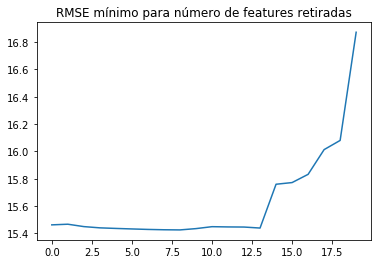

In [21]:
vec = np.array(vec)
plt.plot(vec[:,0], vec[:,1])
plt.title("RMSE mínimo para número de features retiradas")
plt.show()

In [22]:
idx = np.argmin(vec[:,1])
print(vec[idx]) # row with best rmse

[8 15.42533272535064 60 list([0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 18, 19, 20])]


In [23]:
w = mmq_l2(Phi_train[:,vec[idx,3]], y_train, vec[idx, 2])

In [24]:
out_train = linreg(w, Phi_train[:,vec[idx,3]])
out_test_wrapper = linreg(w, Phi_test[:,vec[idx,3]])

In [25]:
print("RMSE do conjunto de treino: {}\nRMSE do conjunto de teste: {}".format(rmse(out_train, y_train), rmse(out_test_wrapper, y_test)))

RMSE do conjunto de treino: 15.395822807597538
RMSE do conjunto de teste: 14.14044056258636


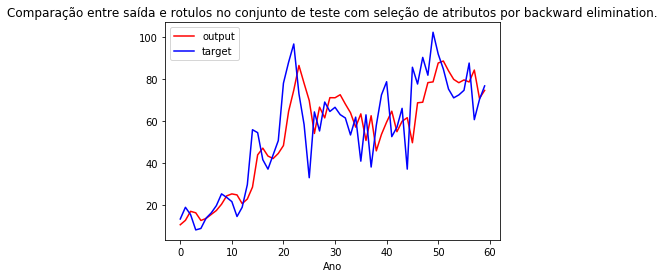

In [26]:
plt.plot(out_test_wrapper, '-r')
plt.plot(y_test, '-b')
plt.xlabel('Ano')
plt.legend(('output', 'target'))
plt.title('Comparação entre saída e rotulos no conjunto de teste com seleção de atributos por backward elimination.')
plt.show()

## c) Seleção de atributos por filtro (correlação de Pearson)

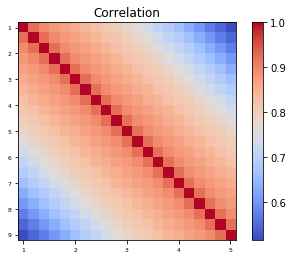

In [27]:
corr = np.corrcoef(np.hstack(( y_train, X_train)).T)
fig = plt.figure()
ax1 = fig.add_subplot(111)
cax = ax1.imshow(corr, interpolation="nearest", cmap='coolwarm')
ax1.grid(False)
plt.title('Correlation')
labels=[e for e in range(21)]
ax1.set_xticklabels(labels,fontsize=6)
ax1.set_yticklabels(labels,fontsize=6)
# Add colorbar, make sure to specify tick locations to match desired ticklabels
fig.colorbar(cax)
plt.show()

In [28]:
mask_corr = list(range(Phi_test.shape[1]))
print("Atributos removidos: ", end="")
for i in range(idx):
    a = np.argmin(corr[0])
    print(a, end=" ")
    mask_corr.remove(a)
    corr[0, a] = 999
print()
print("Atributos selecionados:", mask_corr)

Atributos removidos: 20 19 18 17 16 15 14 13 
Atributos selecionados: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


### Validação cruzada para selecionar o melhor valor de lambda

In [29]:
_, l = kfold(Phi_train[:,mask_corr], y_train, 5, lamb_vec)
print("lambda:", l)

lambda: 30


In [30]:
w = mmq_l2(Phi_train[:,mask_corr], y_train, l)
out_train = linreg(w, Phi_train[:,mask_corr])
out_test_corr = linreg(w, Phi_test[:,mask_corr])

In [31]:
print("RMSE do conjunto de treino: {}\nRMSE do conjunto de teste: {}".format(rmse(out_train, y_train), rmse(out_test_corr, y_test)))

RMSE do conjunto de treino: 15.687326728458537
RMSE do conjunto de teste: 13.865752631349473


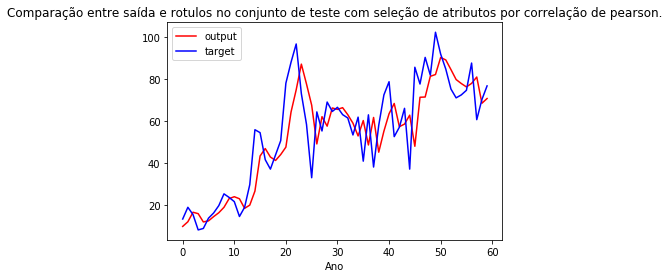

In [32]:
plt.plot(out_test_corr, '-r')
plt.plot(y_test, '-b')
plt.xlabel('Ano')
plt.legend(('output', 'target'))
plt.title('Comparação entre saída e rotulos no conjunto de teste com seleção de atributos por correlação de pearson.')
plt.show()

## Comparação entre as 3 abordagens

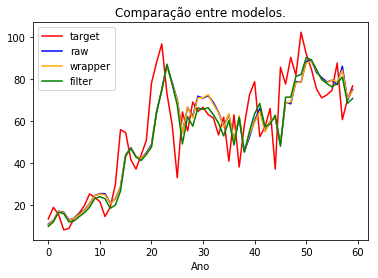

RMSE raw: 14.249451112744566
RMSE wrapper: 14.14044056258636
RMSE filter: 13.865752631349473


In [34]:
plt.plot(y_test, '-r')
plt.plot(out_test, '-b')
plt.plot(out_test_wrapper, 'orange')
plt.plot(out_test_corr, 'g')

plt.xlabel('Ano')
plt.legend(('target', 'raw', 'wrapper', 'filter'))
plt.title('Comparação entre modelos.')
plt.show()

print("RMSE raw: {}".format(rmse(out_test, y_test)))
print("RMSE wrapper: {}".format(rmse(out_test_wrapper, y_test)))
print("RMSE filter: {}".format(rmse(out_test_corr, y_test)))